<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/FrequencyFreaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the FrequencyFreaks notebook. After working through this notebook you will be able to...
  * create gaussian, grating and gabor images
  * load an image and convert it to a grayscale image and interpolate to the size that you want
  * take the 2D discrete Fourier Transform of an image
  * examine components of the Fourier Transform to confirm the way in which orientation and spatial frequency is laid out
  * create a gaussian filter in the Fourier Domain and apply it to an image
  * low-pass or high-pass filter an image
  * apply an oriented band-pass filter to an image by using the convolution theorem to multiply the fourier transform of an appropriate gabor
  * demonstrate that a difference-of-gaussians receptive field will have a difference-of-gaussian contrast sensitivity function as derived in the Enroth-Cugell paper

In [ ]:
# Import libraries that we need
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import imageio as iio
from scipy import interpolate

To get started we are going to need to be able to generate images of grating patterns, gaussians and gabors. To do that we will first define a function that is going to return to us a mesh of x and y points for which we can evaluate our 2D functions.

In [ ]:
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents

Next we will make a function that will compute a circularly symmetric gaussian. You know the mathematical function for a gaussian, yes? (wikipedia will surely know if you don't). Note that we don't need the probability density function which is computed to have a total area of 1. Instead, we just want the simplist, plain vanilla, function to go between 0 and 1. 

In [ ]:
def makeGaussian(x,y,sigma):
  # there it is!
  gaussian = np.exp(-(x**2+y**2)/(2*sigma**2))
  
  # return 
  return gaussian

Ok, now we should have enough to make a grid of points, compute a gaussian and display it.

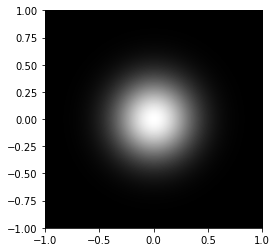

In [ ]:
# get a grid of 513 x 513 mesh points
x, y, extents = getMeshPoints(513)

# make the gaussian with a standard deviation of 0.25
gaussian = makeGaussian(x,y,0.25)

# and display (note that we are setting the colormap to gray, and then showing the x, y extents from -1 to 1)
plt.imshow(gaussian,cmap='gray',extent=extents)

Ok. Now your turn to type some code. Make a gaussian that appears smaller than the one above...

Now let's make a sinusoidal grating. Let's start with an easy one. Say you want to make one in which there is a sinusoidal modulation along the x axis. Then, you should be able to just take your x coordinates from above, pass them throgh a sinusoidal function (let's use cosine) and it should create an image that modulates sinusoidal along the x axis. 

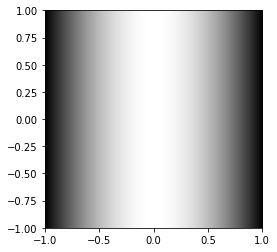

In [ ]:
# compute the grating
grating = np.cos(x)

# and display
plt.imshow(grating,cmap='gray',extent=extents)

Couldn't be easier, could it? Ok. So now we want to control the spatial frequency. We are calculating cosine from -1 to 1 (that's what we set extents to above when we created the function getMeshPoints). So, we'd like to get a sinusoid that goes through one full cycle across the image. Remember that the inputs to the cosine function are in radians, so that means we need to go from -pi to pi across the image. So, easy-peasy, just multiple x by pi and then we will get one full cycle. To be a bit more fancy, let's make it go thrrough 5 cycles/image by multiplying by 5 pi.

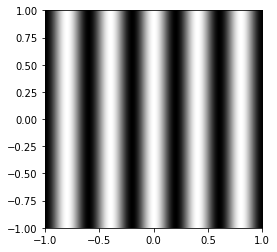

In [ ]:
#compute the grating
grating = np.cos(5*np.pi*x)

# and display
plt.imshow(np.cos(5*np.pi*x),cmap='gray',extent=extents)

Pretty. Ok, now your turn. How would you make a grating that modulates along the y-axis and has a spatial frequency of 3 cycles/image?

Now, let's make it harder. Say you want to change the orientation of the grating to something besides along the x or y axis. Instead you want to give an orientation in degrees where 0 orientation would be modulation along the x-axis and 90 degrees of orientation along the y-axis. 

Well, the solution is pretty simple. Say your angles is theta. Then you will multiply the x value by cos(theta) and the y value by sin(theta) and add those together. What does that do? Well if theta is 0, then you just get the x-value. If theta is 90 degrees, you just get the y-vale. And if theta is in between, you get exactly the right mix of x and y value. Make sense? Let's try it.

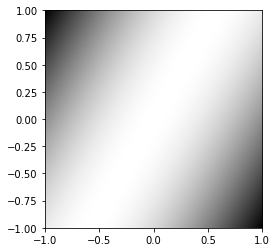

In [ ]:
# set theta in degrees here
theta = 30

# functions want theta in radians, but I can't think in radians
# so here we just convert theta to radians
theta = np.pi*theta/180

# here we compute the grating
grating = np.cos(x*np.cos(theta) + y*np.sin(theta))

# and display
plt.imshow(grating,cmap='gray',extent=extents)

Ok. Cool. So, now let's put two things together. We know how to change the orientation of the grating, and we know how to change the spatial frequency of the grating (by multiplying values). Let's make a function that takes the spatial frequency (in cycles/image) and the orientation (in degrees) and computes a grating.

In [ ]:
def makeGrating(x, y, orientation,spatialFrequency):
  # we wil convert orientation into radians
  orientation = np.pi*orientation/180

  # we need to convert spatial frequency into cycles/image
  # remember that we made the extents in getMeshPoints
  # to go from -1 to 1, so we want that to go from -pi to pi
  spatialFrequency = spatialFrequency * np.pi

  # make the grating
  grating = np.cos(spatialFrequency*(x*np.cos(orientation)+y*np.sin(orientation)))

  # and return
  return grating

Alrighty. Let's test and see if that function works

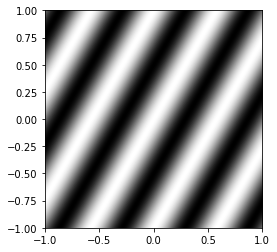

In [ ]:
# make the grating - play around with the orientation and spatial frequency inputs
# and make sure this works!!
grating = makeGrating(x,y,30,4)

# and show
plt.imshow(grating,cmap='gray',extent=extents)

Wooh, hooh! Now we are ready to makie a gabor! Aren't you excited? What is a gabor? Just the product of a grating and a gaussian. It's the basic filter that is used to model V1 receptive fields - and super important because it is analytically very easy to handle - and because it can be used to band-pass filter (i.e. filter for some spatial-frequency band) and orientation filter, as we will see coming up. 

Let's make the gabor.

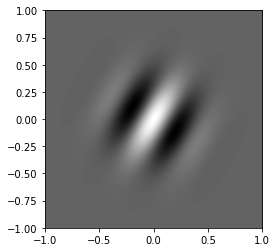

In [ ]:
# just multiply the gaussian by the grating
gabor = makeGaussian(x,y,0.25) * makeGrating(x,y,30,4)

# and plot
plt.imshow(gabor,cmap='gray',extent=extents)

Great. So, let's get right to it. Let's see how we can use these gabors to filter images. First, we need to upload an image and do a little bit of processing to get it into a standard format (just so that it will be easy to handle). In particular, let's just use a grayscale image (handling color is not a problem, you just need to treat each of the RGB components as a separate image and do operationm on each), and let's make it a standard size by interpolating the image we get. Oh, and also let's make it a square image by taking the top-left corner of the image. We'll make a function that can read in an image and return a standardized image which will make it easier to work with.

In [ ]:
def getImage(filename,imageSize):
  # first load the image
  img = iio.imread(filename)

  # make graycale by averaging across color dimensions
  img = img.mean(2)

  # get a square of the image
  imgSquareSize = np.min(img.shape);
  img =img[0:imgSquareSize,0:imgSquareSize]

  # interpolate to preferred size 
  fun = interpolate.interp2d(np.linspace(0,1,imgSquareSize),np.linspace(0,1,imgSquareSize),img,kind='linear')
  img = fun(np.linspace(0,1,imageSize),np.linspace(0,1,imageSize))

  # normalize values to between -1 and 1
  # just because this is a typical and easy way to 
  # think about values of an image 0 is gray -1 is black and 1 is white
  # just like for a sinewave grating!
  img = (img - img.min())/(img.max() - img.min())
  img = 2 * img - 1

  # return the image
  return img 

Now, let's try to load an image. Take an image from anywhere and load into the files tab to the left (png format works so you can use a screen capture if you are on a mac). All you have to do is click on the folder icon at the left near the top and you should see a directory with "sample_data" as one of the folders. Just drag and drop your image over there (i.e. underneath "sample_data", not in the sample_data directory though - below the directory), and then you should be good to go. I'm moving an image called brain_both.png. You will need to change the filename below to make it point to your image.

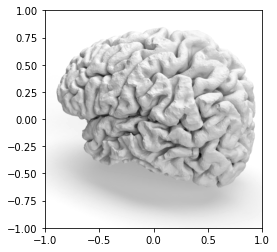

In [ ]:
# load the image
img = getImage("brain_both.png",513)

# and display
plt.imshow(img,cmap='gray',extent=extents)

Alright. Let's get right to it. What does the Fourier transform of this image look like? We will plot the magnitude spectrum which shows the amplitude of each of the sinusoidal gratings that make up an image.

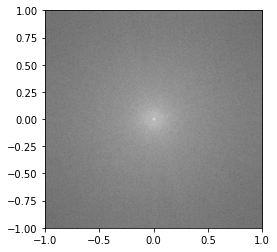

In [ ]:
# take Fourier transform
imgFFT = np.fft.fft2(img)

# now we will shift the image so that the middle will
# be the DC (luminance) component (otherwise, it plots
# in a way that is not as intuitive to understand)
imgFFT = np.fft.fftshift(imgFFT)

# Display the amplitude spectrum by taking the magnitude
# of the fourier transform (note that due to technical reasons
# in how the FFT is computed - with complex exponentials - the
# values of the FFT are complex numbers where the magnitude 
# relfects the weight of the sinusoidal component and the phase
# of the number represents the phase of the sinusoidal component
# needed)
imgMag = np.abs(imgFFT)

# The image spectrum is typicall really hard to see when
# plotted directly because the DC value is really large
# compared to other values, and so the scaling in imshow
# makes it look like one big black square with a bright
# point at the very center. To make it easier to see,
# we normalize the values between 0 and 1 and then
# we are going to pump it through a function that boosts
# up small values to make the image more visible. Not
# really important what this function is, but for your 
# reference, I'm using 1 - exponential function
imgMagNormalized = (imgMag - imgMag.min())/(imgMag.max()-imgMag.min())
imgMagAdjusted = (1-np.exp(-imgMagNormalized**0.1))/(1-np.exp(-1))

# display
plt.imshow(imgMagAdjusted,cmap='gray',extent=extents)


Ok. So how do we interpret this Fourier spectrum? Remember that it has been shifted so the center is the mean luminance (DC offset). IT's best to think of it in radial coordinates where spatial frequency increases as you go out towards the edges and orientation as you go around in a circle around the circle.

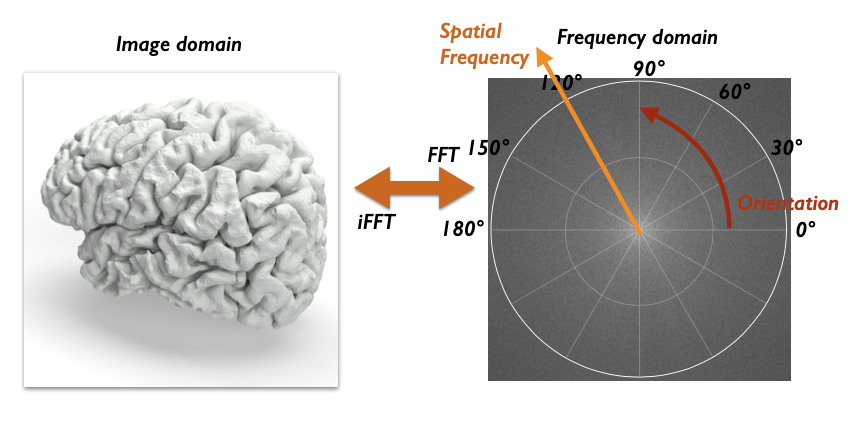


So, let's see if can confirm that. To do that, we could make a Fourier spectrum with amplitude of 1 at one point and then inverse FFT that to make sure it produces a grating with the orientation and spatial frequency that we expect. This is the picture you should have of what we are doing:

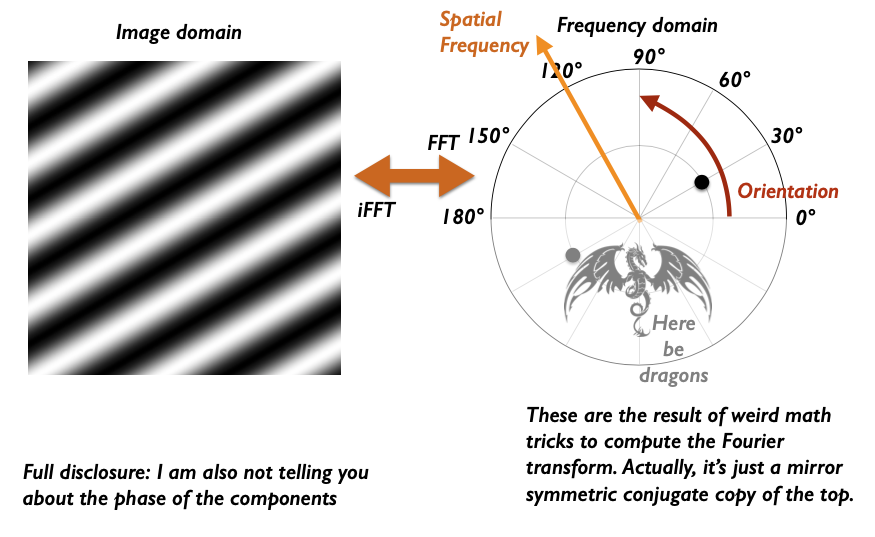

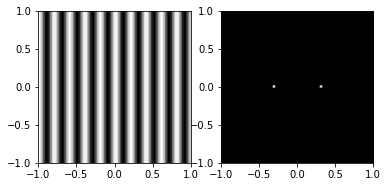

In [ ]:
# size of Fourier Tranform we are making (use an odd number so that the DC is in the center)
fftSize = 65
fftCenter = int((fftSize-1)/2)

# initalize this with all zeros
fftTest = np.zeros([fftSize,fftSize])

# let's put a one in orientation 0 and at a low spatial frequency near the center
# we'll set the location that we want to set by the coordinates xi and yi
xi = 10
yi = 0

# So, set the value to one
fftTest[fftCenter + xi,fftCenter + yi] = 1

# now, we also have to set the one in the bottom half
# of the spectrum - remember that this part is due to
# the crazy way that the FFT is computed, so, don't
# worry about this for now - just know that the FFT
# needs to be mirror-symmetric, so that's what we 
# are doing her
fftTest[fftCenter - xi,fftCenter - yi] = 1

# let's display this fourier spectrum - should be two points (note that
# we are flipping and transposing the image just because of the way that imshow
# displays a matrix)
plt.subplot(122)
plt.imshow(np.flipud(fftTest.T),cmap='gray',extent=extents)

# inverse transform
ifftTest = np.fft.ifft2(np.fft.ifftshift(fftTest))
ifftTest = np.real(ifftTest)

# show
plt.subplot(121)
plt.imshow(np.flipud(ifftTest.T),cmap='gray',extent=extents)

Now, your turn - change the xi and yi coordinates above to make an oblique grating. Or one that has a lower spatial frequency.

Make sense, so now go back and look at the Fourier spectrum that you computed for the image. Each little spot in there shows you the magnitude of the grating of a particular spatial frequency and orientation required to add together to make the image.

Ok. Now let's see if we can filter the FFT spectrum of our image and get a low-pass image of it.

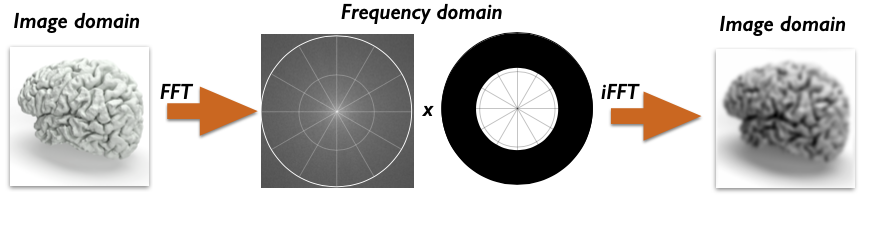

To do the filtering we need to only pass the low spatial frequencies at the center of the image and block frequencies at the edges of the image. We can do that by multiplying one of our gaussian functions with the image (which has the highest values in the center which go towards 0 towards the edge of the image). Then inverse FFT the image and see what we get.

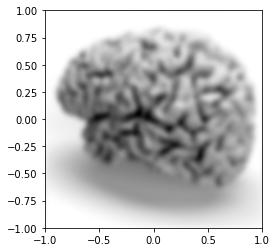

In [ ]:
# make the gaussian image
gauss = makeGaussian(x,y,0.05)

# multiply with the FFT of the image from above
filteredFFT = imgFFT * gauss

# now we inverse fft to get the image back
# remember we haft to use ifftshift to 
# shift the center component back to where
# it expected to be for the fft
filteredFFT = np.fft.ifftshift(filteredFFT)
filteredImg = np.fft.ifft2(filteredFFT)

# take the real component (this has to do with the
# way the FFT is computed with complex exponentials
# the values will all be real with no imaginary
# component, but we still need to convert from complex
# numbers back to real numbers for imshow to work)
filteredImg = np.real(filteredImg)

# and display
plt.imshow(filteredImg,cmap='gray',extent=extents)

Now your turn. Try to make a high-pass filter which only allows high spatial frequencies to pass and blocks low frequencies. Hint: what happens to the gaussian function if you do 1 - gauss? Here is the picture you should have of what we are trying to do:

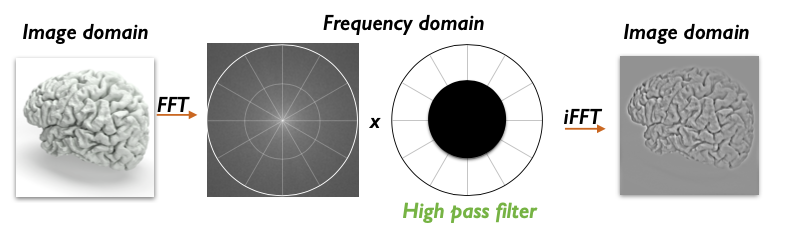

Alright. So now we can make low pass and high pass filters. What about the "oriented band-pass filter". Well, we could think about it in the image domain. If we convolve with the an oriented gabor filter, then we should get what we want. Let's try to do that using the convolution theorem. We will make the filter in the image domain, fourier transform and then multiply by the fourier transform of the image (remember the convolution theorem says this is the same as convolution). Then inverse transform back to the image domain and that should work. Right? Here is the picture of what we are trying to do:

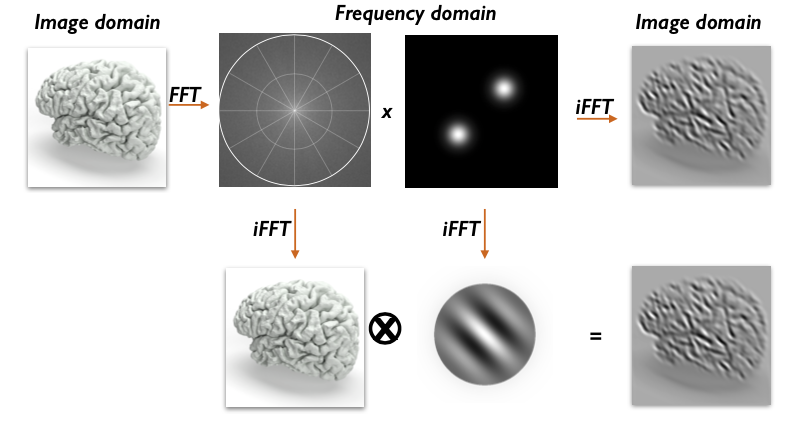

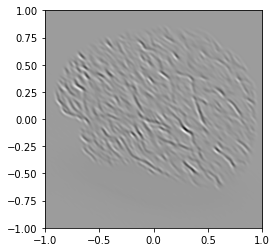

In [ ]:
# Make an oriented gabor filter
gabor = makeGaussian(x,y,0.02) * makeGrating(x,y,-45,48)

# take the fourier transform
gaborFFT = np.fft.fft2(gabor)

# get the fourier transform of the img
imgFFT = np.fft.fft2(img)

# multiply together
filteredImgFFT = gaborFFT * imgFFT

# inverse transform
filteredImg = np.fft.ifft2(filteredImgFFT)

# shift everything back
filteredImg = np.fft.ifftshift(filteredImg)

# take the real component
filteredImg = np.real(filteredImg)

# and display
plt.imshow(filteredImg,cmap='gray',extent=extents)

In the Enroth-Cugell & Robson paper, they write a mathematical proof showing that if the receptive field is described by a difference of gaussian model, then the contrast-sensitivity function is also described by a difference of gaussian models. See for yourself whether this is true. Generate a difference of gaussian receptive fields where the center has a smaller standard deviation than the surround. Take the fourier transform of the receptive field and see what it looks like. 